# Librerías

Para la ejecución de este notebook se va a hacer uso de las siguientes librerías:

- [TensoFlow](https://www.tensorflow.org/install)
- [Keras](https://keras.io/getting_started/)
- [SciKit Learn](https://scikit-learn.org/stable/install.html)
- [MatplotLib](https://matplotlib.org/stable/users/installing/index.html)

## [OPCIONAL]Instalación
> En caso de que no se vaya a ejecutar este notebook fuera del ambiente de Google Colad se debe realizar la instalación de las librerías con los siguientes comandos en la terminal.
```bash
pip install --upgrade pip
pip install -U scikit-learn
pip install tensorflow
pip install -U matplotlib
```

In [ ]:
import os
import numpy as np
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

# from utils.imageUtilities import show_img_from_prediction

# Configuración

En la siguiente paso se definen variables de configuración que se utilizaran a lo largo del proceso.

| Variable           | Descripción                                               |
|--------------------|-----------------------------------------------------------|
| digits_to_predict  | Digitos a predecir                                        |
| img_size           | Tamaño de la imagen                                       |
| img_channels       | Canales de la imagen                                      |
| validation_set_ptg | Porcentaje del set de entrenamiento asignado a validacion |
| TRAIN_EPOCHS       | Numero de epocas                                          |
| FT_EPOCHS          |                                                           |
| BATCH_SIZE         | Tamaño del lote                                           |
| MODEL_FOLDER       | Carpeta del modelo.                                       |

In [2]:
digits_to_predict = 1

img_size = (180, 180)
img_channels = 3

validation_set_ptg = 0.2

TRAIN_EPOCHS = 25
FT_EPOCHS = 50
BATCH_SIZE = 128
# paths
MODEL_FOLDER = 'ptmodel7_1digit_with_bbox'

# Procesamiento de los datos

En este punto vamos a utilizar los datos pre-procesados en el notebook [pre_process_data](pre_process_data.ipynb) del cual se generaron vectores de NumPy

## Carga de los datos

In [3]:
Xtrain = np.load('preprocessed_train/Xtrain2.npy')
labels = np.load('preprocessed_train/labels2.npy')
bboxes = np.load('preprocessed_train/bboxes2.npy')
imagePaths = np.load('preprocessed_train/imagePaths2.npy')

In [4]:
print(Xtrain.shape)
print(labels.shape)
print(bboxes.shape)
print(imagePaths.shape)

(14522, 180, 180, 3)
(14522, 10)
(14522, 4)
(14522,)


## Separación de los datos

En este punto separamos los datos para entrenamiento y pruebas, para este caso se utiliza el 20% de los datos para pruebas y 80% para entrenamiento.

In [5]:
split = train_test_split(Xtrain, labels, bboxes, imagePaths,
	test_size=validation_set_ptg, random_state=42)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# Construcción del modelo

## Definición de las capas del modelo.

A continuación definimos las capas que van a componer el modelo, utilizando un modelo pre entrenado VGG19 con 144 millones de parámetros y un peso de 549mb

In [6]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.125),
        tf.keras.layers.RandomZoom(0.2),
    ]
)
inputs = Input(shape=(*img_size, img_channels))
augmented_data = data_augmentation(inputs)
# load the VGG19 network, ensuring the head FC layers are left off
vgg = VGG19(weights="imagenet", include_top=False,
	input_tensor=augmented_data)
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(digits_to_predict * 4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(256, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(labels[0]), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

80134624/80134624 [==============================] - 1s 0us/step


## Compilación del modelo

En este punto se compila el modelo definiendo su la función de perdida utilizando un `categorical_crossentropy` y el optimizador `Adam`

In [7]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss
lossWeights = {
	"class_label": 0.8,
	"bounding_box": 0.2
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam()
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 180, 180, 64  1792        ['sequential[0][0]']             
                                )                                                                 
                                                                                              

# Entrenamiento del Modelo

## Definición de diccionarios

Procedemos a definir dos diccionarios donde se definen las etiquetas de clase para cada `bounding-box` tanto para el set de entrenamiento como para el set de prueba.


In [8]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

## Ejecución de entrenamiento

Una vez con los diccionarios definidos podemos dar paso al entrenamiento del modelo, pasando como parámetros los diccionarios los sets de validación y la cantidad de epochs y el tamaño de batch a utilizar. Por último se guarda el modelo en formato `.h5` y el respectivo vector histórico.

> La ejecución de cada época puede tardar al rededor ~120 segundos

In [9]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=TRAIN_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(f'models/{MODEL_FOLDER}/model.h5', save_format="h5")
print("[INFO] saving history...")
np.save(f'models/{MODEL_FOLDER}/model_history.npy', H.history)

[INFO] training model...
Epoch 1/25
91/91 [==============================] - 143s 1s/step - loss: 1.8860 - bounding_box_loss: 0.0094 - class_label_loss: 2.3552 - bounding_box_accuracy: 0.9708 - class_label_accuracy: 0.1335 - val_loss: 1.7531 - val_bounding_box_loss: 0.0066 - val_class_label_loss: 2.1897 - val_bounding_box_accuracy: 0.9793 - val_class_label_accuracy: 0.1859
Epoch 2/25
91/91 [==============================] - 122s 1s/step - loss: 1.7612 - bounding_box_loss: 0.0069 - class_label_loss: 2.1997 - bounding_box_accuracy: 0.9811 - class_label_accuracy: 0.1620 - val_loss: 1.6957 - val_bounding_box_loss: 0.0063 - val_class_label_loss: 2.1180 - val_bounding_box_accuracy: 0.9793 - val_class_label_accuracy: 0.1935
Epoch 3/25
91/91 [==============================] - 122s 1s/step - loss: 1.7383 - bounding_box_loss: 0.0067 - class_label_loss: 2.1712 - bounding_box_accuracy: 0.9811 - class_label_accuracy: 0.1639 - val_loss: 1.7143 - val_bounding_box_loss: 0.0059 - val_class_label_loss: 

# Resultados

## Comparativa de función de perdida

La siguiente celda nos permite observar el valor de perdida por cada época.

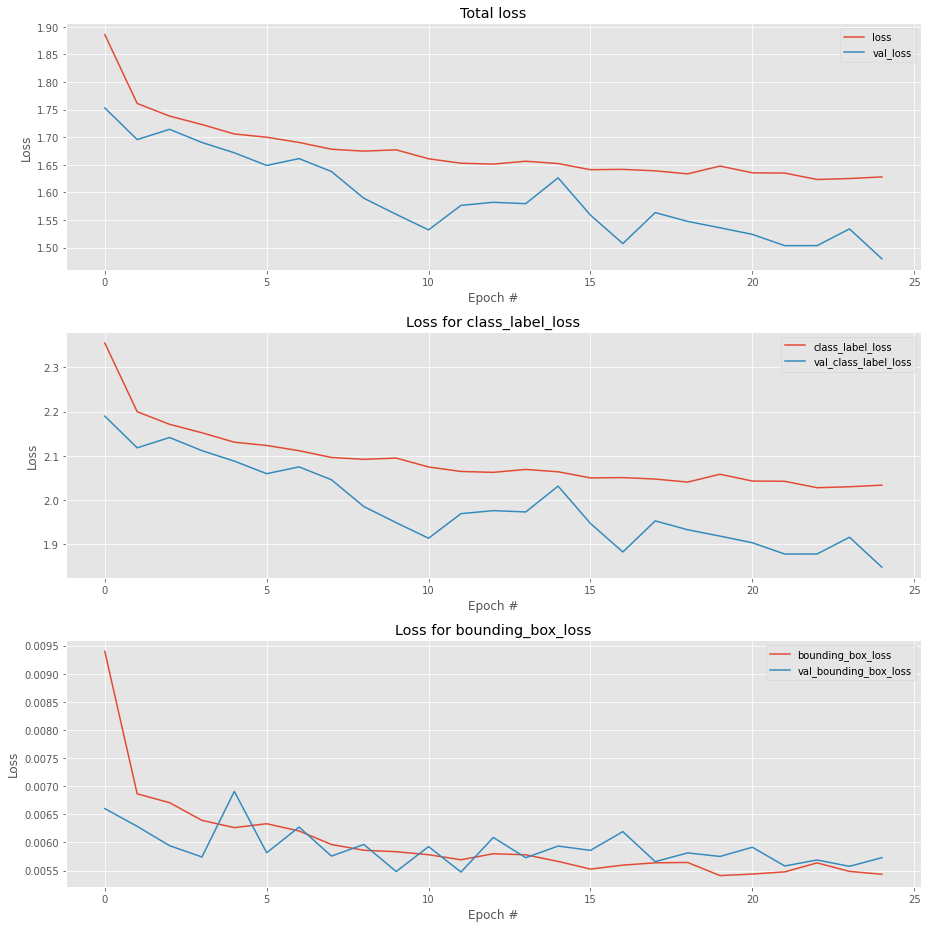

In [10]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, TRAIN_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join(['models',MODEL_FOLDER,'plots', "losses.png"])
plt.savefig(plotPath)

In [11]:
H.history.keys()

dict_keys(['loss', 'bounding_box_loss', 'class_label_loss', 'bounding_box_accuracy', 'class_label_accuracy', 'val_loss', 'val_bounding_box_loss', 'val_class_label_loss', 'val_bounding_box_accuracy', 'val_class_label_accuracy'])

## Comparativa de precisión

En el siguiente gráfico se puede comprar los valores de precisión por época para el set de entrenamiento con el de validación.

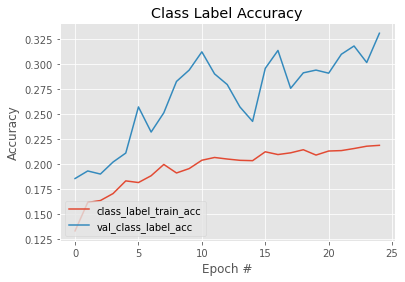

In [12]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join(['models',MODEL_FOLDER,'plots', "accs.png"])
plt.savefig(plotPath)

# Fine Tuning

Dado a los resultados procedemos a hacer un fine tuning para mejorar la precisión del modelo.

In [13]:
vgg.trainable = True

opt = Adam(learning_rate = .00001)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 180, 180, 64  1792        ['sequential[0][0]']             
                                )                                                                 
                                                                                              

## Compilación del modelo

Compilamos el modelo con el Fine Tuning y se procede a guardarlo en un formato `.h5`

> Cada época puede llegar a tardar ~150 segundos

In [14]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(                   
        filepath=f'models/{MODEL_FOLDER}/best_model_ft.hdf5',              
        monitor="val_loss",                            
        save_best_only=True,                           
    )
]
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
    callbacks=callbacks_list,
	batch_size=BATCH_SIZE,
	epochs=FT_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(f'models/{MODEL_FOLDER}/model_ft.h5', save_format="h5")
print("[INFO] saving history...")
np.save(f'models/{MODEL_FOLDER}/model_ft_history.npy', H.history)

[INFO] training model...
Epoch 1/50
91/91 [==============================] - 168s 2s/step - loss: 1.5943 - bounding_box_loss: 0.0056 - class_label_loss: 1.9915 - bounding_box_accuracy: 0.9811 - class_label_accuracy: 0.2317 - val_loss: 1.3712 - val_bounding_box_loss: 0.0055 - val_class_label_loss: 1.7127 - val_bounding_box_accuracy: 0.9793 - val_class_label_accuracy: 0.3952
Epoch 2/50
91/91 [==============================] - 150s 2s/step - loss: 1.5680 - bounding_box_loss: 0.0057 - class_label_loss: 1.9586 - bounding_box_accuracy: 0.9811 - class_label_accuracy: 0.2410 - val_loss: 1.3365 - val_bounding_box_loss: 0.0057 - val_class_label_loss: 1.6692 - val_bounding_box_accuracy: 0.9793 - val_class_label_accuracy: 0.4172
Epoch 3/50
91/91 [==============================] - 149s 2s/step - loss: 1.5499 - bounding_box_loss: 0.0057 - class_label_loss: 1.9360 - bounding_box_accuracy: 0.9811 - class_label_accuracy: 0.2515 - val_loss: 1.3671 - val_bounding_box_loss: 0.0055 - val_class_label_loss: 

# Resultados finales

## Comparación de perdida

En el siguiente gráfico podemos ver la comparación del resultado de la función de perdida del entrenamiento y la validación en el transcurso de cada época.

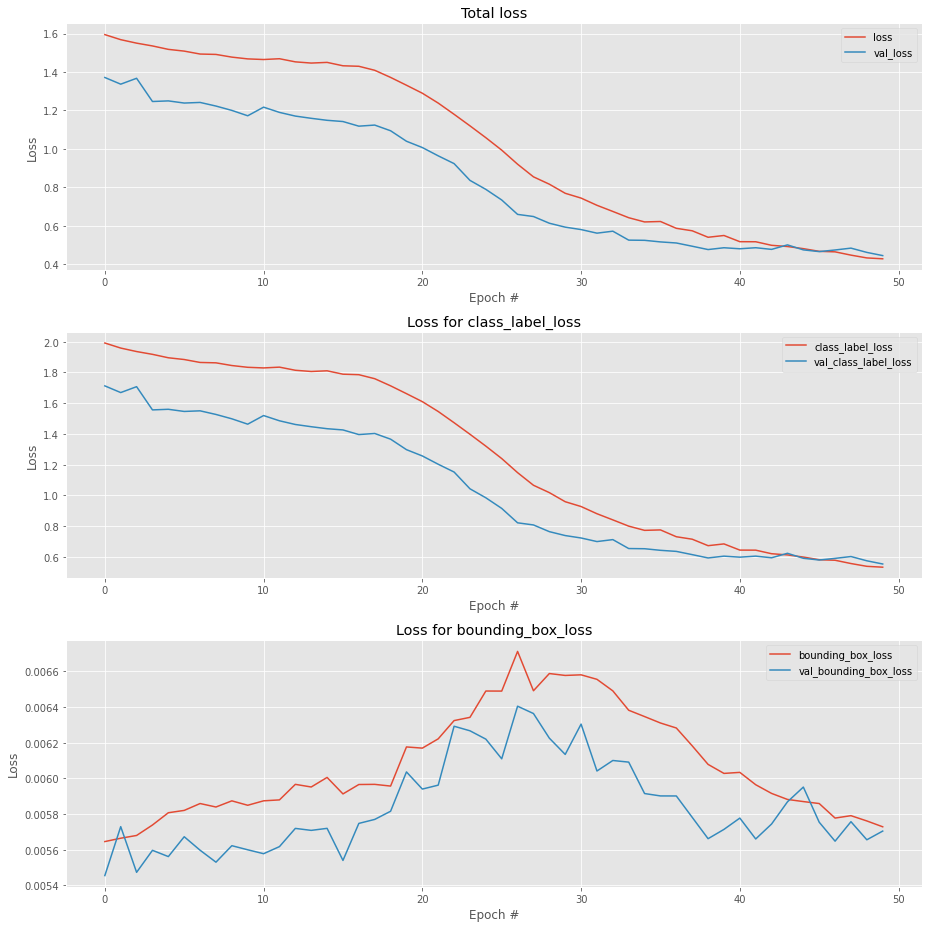

In [15]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, FT_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join(['models',MODEL_FOLDER,'plots', "ft_losses.png"])
plt.savefig(plotPath)

## Comparación de precisión

El siguiente gráfico nos muestra la el resultado de precisión para cada época.

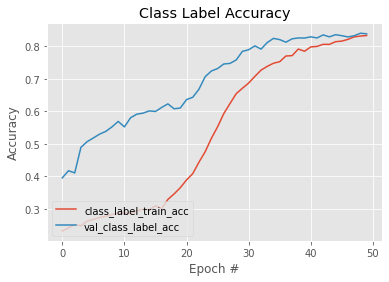

In [16]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join(['models',MODEL_FOLDER,'plots', "ft_accs.png"])
plt.savefig(plotPath)

## Mejor modelo Fine Tuning

Cargamos el mejor modelo con que resulto del Fine Tuning

In [17]:
model = tf.keras.models.load_model(f'models/{MODEL_FOLDER}/best_model_ft.hdf5')

In [18]:
rng = np.random.default_rng(4)
samples_ids = rng.integers(0, testPaths.size, 25)
samples_ids

array([2110, 2739, 2560, 1485, 2731, 2835, 2818,  234, 1317, 1764,  822,
       1093, 1821, 2329, 1687,  507, 1963, 2532,  638, 1580,  982, 2620,
        175, 1386, 2607])

Se realiza una predicción con un vector de datos de ejemplo.

In [19]:
pred = model.predict(testImages[samples_ids])

1/1 [==============================] - 1s 1s/step


Se define métodos que ayudan a visualizar imágenes con los bonded-box del dígito detectado

In [20]:
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_img_from_filename(filename, ax=None, bboxes=[]):
  tf_img = io.read_file(filename)
  tf_img = image.decode_png(tf_img, channels=3)

  axis = ax or plt
  axis.imshow(tf_img)

  # Plot the bounding boxes
  for bbox in bboxes:
    rect = patches.Rectangle((bbox['left'], bbox['top']), bbox['width'], bbox['height'], linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect)
    # Plot the label of each bounding box
    annot = axis.annotate(int(bbox['label']), (bbox['left'],bbox['top'] - 5), annotation_clip=False, bbox=dict(boxstyle="round", fc="w"),  arrowprops=dict(arrowstyle="->"))
    annot.set(fontsize=12)

def show_img_from_prediction(filename, boxes, labels, ax=None):
  tf_img = io.read_file(filename)
  tf_img = image.decode_png(tf_img, channels=3)
  h, w, channels = tf_img.shape

  axis = ax or plt
  axis.imshow(tf_img)

  for i in range(0, boxes.size, 4):
    startX, startY, endX, endY, *boxes = boxes

    top = startY
    left = startX
    width = endX - startX
    height = endY - startY

    top *= h
    height *= h
    left *= w
    width *= w

    rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect)
    # Plot the label of each bounding box
    annot = axis.annotate(np.argmax(labels), (left, top + height + 5), annotation_clip=False, bbox=dict(boxstyle="round", fc="w"),  arrowprops=dict(arrowstyle="->"))
    annot.set(fontsize=12)

Visualizamos la imagenes con los bounded-box y el dígito que predijo el modelo.

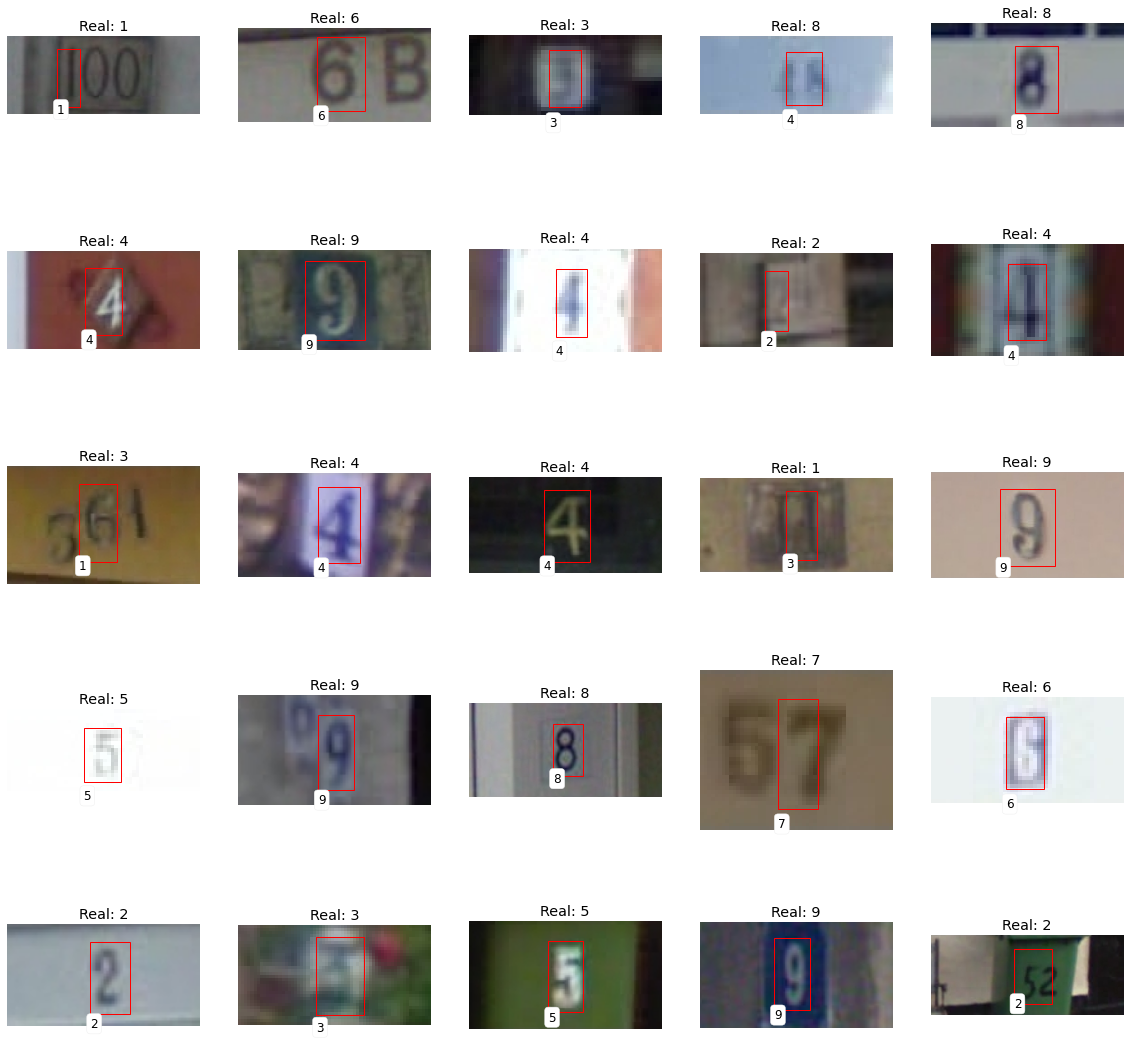

In [21]:
import numpy as np
fig, axs = plt.subplots(5, 5, figsize=(20,20))
for i, ax in zip(range(pred[0].size), axs.flatten()):
  ax.axis('off')
  ax.set_title(f'Real: {np.argmax(testLabels[samples_ids[i]])}')
  show_img_from_prediction(testPaths[samples_ids[i]], pred[0][i,:], pred[1][i,:], ax=ax)

# Pruebas del set validación

Se carga el mejor modelo encontrado con el Fine Tuning nuevamente para tener una prueba limpia

In [22]:
model = tf.keras.models.load_model(f'models/{MODEL_FOLDER}/best_model_ft.hdf5')

Cargamos los datos de prueba guardados previamente como vectores de NumPy

In [23]:
Xtest = np.load('preprocessed_test/Xdata.npy')
labels = np.load('preprocessed_test/labels.npy')
bboxes = np.load('preprocessed_test/bboxes.npy')
imagePaths = np.load('preprocessed_test/imagePaths.npy')

In [24]:
testTargets = {
	"class_label": labels,
	"bounding_box": bboxes
}

Se procede a evaluar el set de pruebas que se ha cargado.

In [25]:
model.evaluate(Xtest, testTargets)

78/78 [==============================] - 6s 51ms/step - loss: 0.8052 - bounding_box_loss: 0.0104 - class_label_loss: 1.0038 - bounding_box_accuracy: 0.9211 - class_label_accuracy: 0.7237


[0.8051598072052002,
 0.010403558611869812,
 1.003848671913147,
 0.921063244342804,
 0.7237213253974915]

In [26]:
rng = np.random.default_rng(6)
samples_ids = rng.integers(0, imagePaths.size, 25)
samples_ids

array([1105, 1336, 1285,  852, 2349,  916, 1633,  929, 1117, 2451,  463,
       1571, 1060, 1674, 1876,  819, 1669, 1688, 1122,  305, 1533,  128,
       2199, 2111, 2101])

Se realiza la predicción con los datos de prueba únicamente para ciertos elementos de pruba.

In [27]:
pred = model.predict(Xtest[samples_ids])

1/1 [==============================] - 0s 237ms/step


Graficamos las imágenes con los bounded-box y los dígitos que predijo el modelo.

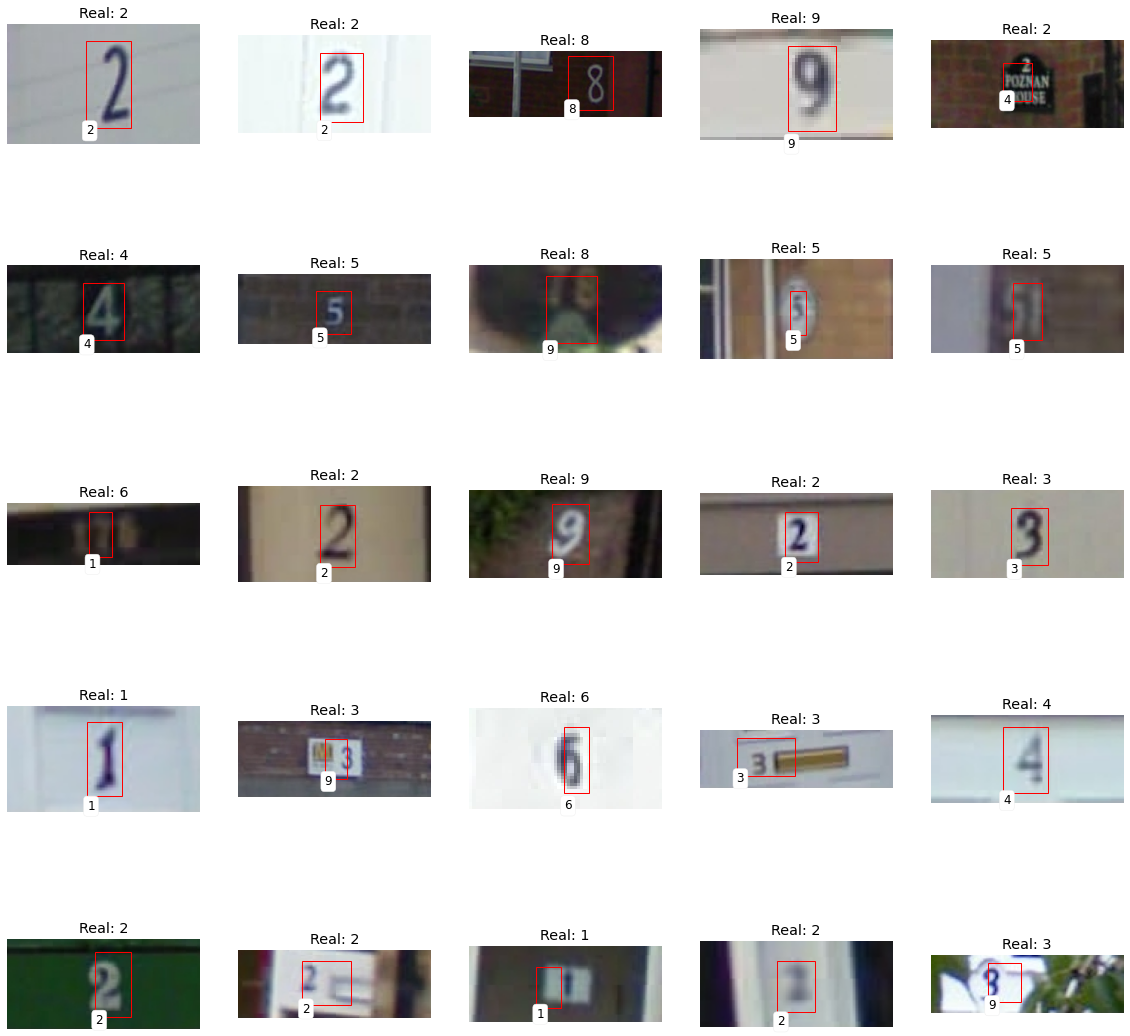

In [28]:
fig, axs = plt.subplots(5, 5, figsize=(20,20))
for i, ax in zip(range(pred[0].size), axs.flatten()):
  ax.axis('off')
  ax.set_title(f'Real: {np.argmax(labels[samples_ids[i]])}')
  show_img_from_prediction(imagePaths[samples_ids[i]], pred[0][i,:], pred[1][i,:], ax=ax)

## Matriz de confusión

Se realiza una nueva predicción, pero esta vez con el set de pruebas completo.

In [29]:
preds = model.predict(Xtest)

78/78 [==============================] - 3s 35ms/step


In [30]:
consfusion_matrix = tf.math.confusion_matrix(np.argmax(labels, axis=1),np.argmax(preds[1], axis=1))

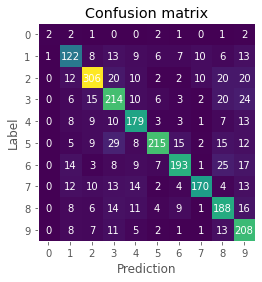

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(consfusion_matrix)
num_classes = len(labels[0])

# Show all ticks and label them
plt.xticks(np.arange(num_classes), np.arange(num_classes))
plt.yticks(np.arange(num_classes), np.arange(num_classes))

# Loop over data dimensions and create text annotations.
for i in range(num_classes):
    for j in range(num_classes):
        text = ax.text(j, i, consfusion_matrix[i, j].numpy(), ha="center", va="center", color="w")

ax.set_title("Confusion matrix")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.grid(False)
plotPath = os.path.sep.join(['models',MODEL_FOLDER,'plots', "confusion_matrix.png"])
plt.savefig(plotPath)
plt.show()